# Portfolio
This macro shows in detail the use of the quadratic programming package quadp .
Running this macro :

```cpp
    .x portfolio.C+
```

or

```cpp
gSystem->Load("libQuadp");
.L portFolio.C+; portfolio()
```

Let's first review what we exactly mean by "quadratic programming" :

We want to minimize the following objective function :

  $ c^T x + ( 1/2 ) x^T Q x $  wrt. the vector $ x $

 $ c $ is a vector and $ Q $ a symmetric positive definite matrix

You might wonder what is so special about this objective which is quadratic in
the unknowns, that can not be done by Minuit/Fumili . Well, we have in addition
the following boundary conditions on $ x $:

 $$
         A x =  b \\
 clo \le  C x \le cup \\
 xlo \le    x \le xup
 $$  where A and C are arbitrary matrices and the rest are vectors

Not all these constraints have to be defined . Our example will only use $ xlo $,
Still, this could be handled by a general non-linear minimizer like Minuit by introducing
so-called "slack" variables . However, quadp is tailored to objective functions not more
complex than being quadratic . This allows usage of solving techniques which are even
stable for problems involving for instance 500 variables, 100 inequality conditions
and 50 equality conditions .

Enough said about quadratic programming, let's return to our example .
Suppose, after a long day of doing physics, you have a look at your investments and
realize that an early retirement is not possible, given the returns of your stocks .
So what now ? ROOT to the rescue ...

In 1990 Harry Markowitz was awarded the Nobel prize for economics: " his work provided new tools
for weighing the risks and rewards of different investments and for valuing corporate stocks and bonds" .
In plain English, he developed the tools to balance greed and fear, we want the maximum return
with the minimum amount of risk. Our stock portfolio should be at the
["Efficient Frontier"](see http://www.riskglossary.com/articles/efficient_frontier.htm).
To quantify better the risk we are willing to take, we define a utility function $ U(x) $. It describes
as a function of our total assets $ x $, our "satisfaction" . A common choice is $ 1-exp(-k*x) $ (the reason for
the exponent will be clear later)  . The parameter $ k $ is the risk-aversion factor . For small values of $ k $
the satisfaction is small for small values of $ x $; by increasing $ x $ the satisfaction can still be increased
significantly . For large values of $ k $, $ U(x) $ increases rapidly to 1, there is no increase in satisfaction
for additional dollars earned .

In summary :
 - small $ k $ ==> risk-loving investor
 - large $ k $ ==> risk-averse investor

Suppose we have for nrStocks the historical daily returns $ r = closing_price(n) - closing_price(n-1) $.
Define a vector $ x $ of length of $ nrStocks $, which contains the fraction of our money invested in
each stock . We can calculate the average daily return $ z $ of our portfolio and its variance using
the portfolio covariance Covar :

 $ z = r^T x $  and $ var = x^T Covar x $

Assuming that the daily returns have a Normal distribution, $ N(x) $, so will $ z $ with mean $ r^T x $
and variance $ x^T Covar x $

The expected value of the utility function is :

 $$
E(u(x)) = Int (1-exp(-k*x) N(x) dx \\
        = 1-exp(-k (r^T x - 0.5 k x^T Covar x) ) \\
 $$

Its value is maximised by maximising $ r^T x -0.5 k x^T Covar x $
under the condition $ sum (x_i) = 1 $, meaning we want all our money invested and

For 10 stocks we got the historical daily data for Sep-2000 to Jun-2004:

 - GE   : General Electric Co
 - SUNW : Sun Microsystems Inc
 - QCOM : Qualcomm Inc
 - BRCM : Broadcom Corp
 - TYC  : Tyco International Ltd
 - IBM  : International Business Machines Corp
 - AMAT : Applied Materials Inc
 - C    : Citigroup Inc
 - PFE  : Pfizer Inc
 - HD   : Home Depot Inc

We calculate the optimal portfolio for 2.0 and 10.0 .

Food for thought :
- We assumed that the stock returns have a Normal distribution . Check this assumption by
  histogramming the stock returns !
- We used for the expected return in the objective function, the flat average over a time
  period . Investment firms will put significant resources in improving the return prediction .
- If you want to trade significant number of shares, several other considerations have
  to be taken into account :
   +  If you are going to buy, you will drive the price up (so-called "slippage") .
      This can be taken into account by adding terms to the objective
      (Google for "slippage optimization")
   +  FTC regulations might have to be added to the inequality constraints
- Investment firms do not want to be exposed to the "market" as defined by a broad
  index like the S&P and "hedge" this exposure away . A perfect hedge this can be added
   as an equality constrain, otherwise add an inequality constrain .




**Author:** Eddy Offermann  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 02:31 AM.</small></i>

In [1]:
%%cpp -d
#include "Riostream.h"
#include "TCanvas.h"
#include "TFile.h"
#include "TMath.h"
#include "TTree.h"
#include "TArrayF.h"
#include "TH1.h"
#include "TF1.h"
#include "TLegend.h"
#include "TSystem.h"

#include "TMatrixD.h"
#include "TMatrixDSym.h"
#include "TVectorD.h"
#include "TQpProbDens.h"
#include "TGondzioSolver.h"

const Int_t nrStocks = 10;
static const Char_t *stocks[] =
     {"GE","SUNW","QCOM","BRCM","TYC","IBM","AMAT","C","PFE","HD"};

class TStockDaily  {
public:
  Int_t fDate;
  Int_t fOpen;     // 100*open_price
  Int_t fHigh;     // 100*high_price
  Int_t fLow;      // 100*low_price
  Int_t fClose;    // 100*close_price
  Int_t fVol;
  Int_t fCloseAdj; // 100*close_price adjusted for splits and dividend

  TStockDaily() {
     fDate = fVol = fOpen = fHigh = fLow = fClose = fCloseAdj = 0;
  }
  virtual ~TStockDaily() {}

  ClassDef(TStockDaily,1)
};







#ifndef __MAKECINT__


#endif

 ---------------------------------------------------------------------------
 

In [2]:
%%cpp -d
Double_t RiskProfile(Double_t *x, Double_t *par) {
  Double_t riskFactor = par[0];
  return 1-TMath::Exp(-riskFactor*x[0]);
}

 ---------------------------------------------------------------------------
 

In [3]:
%%cpp -d
TArrayF &StockReturn(TFile *f,const TString &name,Int_t sDay,Int_t eDay)
{
  TTree *tDaily = (TTree*)f->Get(name);
  TStockDaily *data = 0;
  tDaily->SetBranchAddress("daily",&data);
  TBranch *b_closeAdj = tDaily->GetBranch("fCloseAdj");
  TBranch *b_date     = tDaily->GetBranch("fDate");

  //read only the "adjusted close" branch for all entries
  const Int_t nrEntries = (Int_t)tDaily->GetEntries();
  TArrayF closeAdj(nrEntries);
  for (Int_t i = 0; i < nrEntries; i++) {
    b_date->GetEntry(i);
    b_closeAdj->GetEntry(i);
    if (data->fDate >= sDay && data->fDate <= eDay)
      closeAdj[i] = data->fCloseAdj/100.;
  }

  TArrayF *r = new TArrayF(nrEntries-1);
  for (Int_t i = 1; i < nrEntries; i++)
//    (*r)[i-1] = closeAdj[i]-closeAdj[i-1];
    (*r)[i-1] = closeAdj[i]/closeAdj[i-1];

  return *r;
}

 ---------------------------------------------------------------------------
 

In [4]:
%%cpp -d
TVectorD OptimalInvest(Double_t riskFactor,TVectorD r,TMatrixDSym Covar)
{
// what the quadratic programming package will do:
//
//  minimize    c^T x + ( 1/2 ) x^T Q x
//  subject to                A x  = b
//                    clo <=  C x <= cup
//                    xlo <=    x <= xup
// what we want :
//
//  maximize    c^T x - k ( 1/2 ) x^T Q x
//  subject to        sum_x x_i = 1
//                    0 <= x_i

  // We have nrStocks weights to determine,
  // 1 equality- and 0 inequality- equations (the simple square boundary
  // condition (xlo <= x <= xup) does not count)

  const Int_t nrVar     = nrStocks;
  const Int_t nrEqual   = 1;
  const Int_t nrInEqual = 0;

  // flip the sign of the objective function because we want to maximize
  TVectorD    c = -1.*r;
  TMatrixDSym Q = riskFactor*Covar;

  // equality equation
  TMatrixD A(nrEqual,nrVar); A = 1;
  TVectorD b(nrEqual); b = 1;

  // inequality equation
  //
  // - although not applicable in the current situation since nrInEqual = 0, one
  //   has to specify not only clo and cup but also an index vector iclo and icup,
  //   whose values are either 0 or 1 . If iclo[j] = 1, the lower boundary condition
  //   is active on x[j], etc. ...

  TMatrixD C   (nrInEqual,nrVar);
  TVectorD clo (nrInEqual);
  TVectorD cup (nrInEqual);
  TVectorD iclo(nrInEqual);
  TVectorD icup(nrInEqual);

  // simple square boundary condition : 0 <= x_i, so only xlo is relevant .
  // Like for clo and cup above, we have to define an index vector ixlo and ixup .
  // Since each variable has the lower boundary, we can set the whole vector
  // ixlo = 1

  TVectorD xlo (nrVar); xlo  = 0;
  TVectorD xup (nrVar); xup  = 0;
  TVectorD ixlo(nrVar); ixlo = 1;
  TVectorD ixup(nrVar); ixup = 0;

  // setup the quadratic programming problem . Since a small number of variables are
  // involved and "Q" has everywhere entries, we chose the dense version "TQpProbDens" .
  // In case of a sparse formulation, simply replace all "Dens" by "Sparse" below and
  // use TMatrixDSparse instead of TMatrixDSym and TMatrixD

  TQpProbDens *qp = new TQpProbDens(nrVar,nrEqual,nrInEqual);

  // stuff all the matrices/vectors defined above in the proper places

  TQpDataDens *prob = (TQpDataDens *)qp->MakeData(c,Q,xlo,ixlo,xup,ixup,A,b,C,clo,iclo,cup,icup);

  // setup the nrStock variables, vars->fX will contain the final solution

  TQpVar      *vars  = qp->MakeVariables(prob);
  TQpResidual *resid = qp->MakeResiduals(prob);

  // Now we have to choose the method of solving, either TGondzioSolver or TMehrotraSolver
  // The Gondzio method is more sophisticated and therefore numerically more involved
  // If one want the Mehrotra method, simply replace "Gondzio" by "Mehrotra" .

  TGondzioSolver *s = new TGondzioSolver(qp,prob);
  const Int_t status = s->Solve(prob,vars,resid);

  const TVectorD weight = vars->fX;

  delete qp; delete prob; delete vars; delete resid; delete s;
  if (status != 0) {
    cout << "Could not solve this problem." <<endl;
    return TVectorD(nrStocks);
  }

  return weight;
}

In [5]:
const Int_t sDay = 20000809;
const Int_t eDay = 20040602;

const char *fname = "stock.root";
TFile *f = 0;
if (!gSystem->AccessPathName(fname)) {
   f = TFile::Open(fname);
} else if (!gSystem->AccessPathName(Form("%s/quadp/%s", TROOT::GetTutorialDir().Data(), fname))) {
   f = TFile::Open(Form("%s/quadp/%s", TROOT::GetTutorialDir().Data(), fname));
} else {
   printf("accessing %s file from http://root.cern.ch/files\n",fname);
   f = TFile::Open(Form("http://root.cern.ch/files/%s",fname));
}
if (!f) return;

TArrayF *data = new TArrayF[nrStocks];
for (Int_t i = 0; i < nrStocks; i++) {
   const TString symbol = stocks[i];
   data[i] = StockReturn(f,symbol,sDay,eDay);
}

const Int_t nrData = data[0].GetSize();

TVectorD r(nrStocks);
for (Int_t i = 0; i < nrStocks; i++)
   r[i] = data[i].GetSum()/nrData;

TMatrixDSym Covar(nrStocks);
for (Int_t i = 0; i < nrStocks; i++) {
   for (Int_t j = 0; j <= i; j++) {
      Double_t sum = 0.;
      for (Int_t k = 0; k < nrData; k++) {
         sum += (data[i][k] - r[i]) * (data[j][k] - r[j]);
      }
      Covar(i,j) = Covar(j,i) = sum/nrData;
   }
}

const TVectorD weight1 = OptimalInvest(2.0,r,Covar);
const TVectorD weight2 = OptimalInvest(10.,r,Covar);

cout << "stock     daily  daily   w1     w2" <<endl;
cout << "symb      return sdv              " <<endl;
for (Int_t i = 0; i < nrStocks; i++)
   printf("%s\t: %.3f  %.3f  %.3f  %.3f\n",stocks[i],r[i],TMath::Sqrt(Covar[i][i]),weight1[i],weight2[i]);

TCanvas *c1 = new TCanvas("c1","Portfolio Optimizations",10,10,800,900);
c1->Divide(1,2);

stock     daily  daily   w1     w2
symb      return sdv              
GE	: 1.001  0.022  0.000  0.134
SUNW	: 1.004  0.047  0.676  0.145
QCOM	: 1.001  0.039  0.000  0.000
BRCM	: 1.003  0.056  0.179  0.035
TYC	: 1.001  0.042  0.145  0.069
IBM	: 1.001  0.023  0.000  0.096
AMAT	: 1.001  0.040  0.000  0.000
C	: 1.000  0.023  0.000  0.000
PFE	: 1.000  0.019  0.000  0.424
HD	: 1.001  0.029  0.000  0.098


Utility function / risk profile

In [6]:
c1->cd(1);
gPad->SetGridx();
gPad->SetGridy();

TF1 *f1 = new TF1("f1",RiskProfile,0,2.5,1);
f1->SetParameter(0,2.0);
f1->SetLineColor(49);
f1->Draw("AC");
f1->GetHistogram()->SetXTitle("dollar");
f1->GetHistogram()->SetYTitle("utility");
f1->GetHistogram()->SetMinimum(0.0);
f1->GetHistogram()->SetMaximum(1.0);
TF1 *f2 = new TF1("f2",RiskProfile,0,2.5,1);
f2->SetParameter(0,10.);
f2->SetLineColor(50);
f2->Draw("CSAME");

TLegend *legend1 = new TLegend(0.50,0.65,0.70,0.82);
legend1->AddEntry(f1,"1-exp(-2.0*x)","l");
legend1->AddEntry(f2,"1-exp(-10.*x)","l");
legend1->Draw();

Vertical bar chart of portfolio distribution

In [7]:
c1->cd(2);
TH1F *h1 = new TH1F("h1","Portfolio Distribution",nrStocks,0,0);
TH1F *h2 = new TH1F("h2","Portfolio Distribution",nrStocks,0,0);
h1->SetStats(0);
h1->SetFillColor(49);
h2->SetFillColor(50);
h1->SetBarWidth(0.45);
h1->SetBarOffset(0.1);
h2->SetBarWidth(0.4);
h2->SetBarOffset(0.55);
for (Int_t i = 0; i < nrStocks; i++) {
   h1->Fill(stocks[i],weight1[i]);
   h2->Fill(stocks[i],weight2[i]);
}

h1->Draw("BAR2 HIST");
h2->Draw("BAR2SAME HIST");

TLegend *legend2 = new TLegend(0.50,0.65,0.70,0.82);
legend2->AddEntry(h1,"high risk","f");
legend2->AddEntry(h2,"low  risk","f");
legend2->Draw();

Draw all canvases 

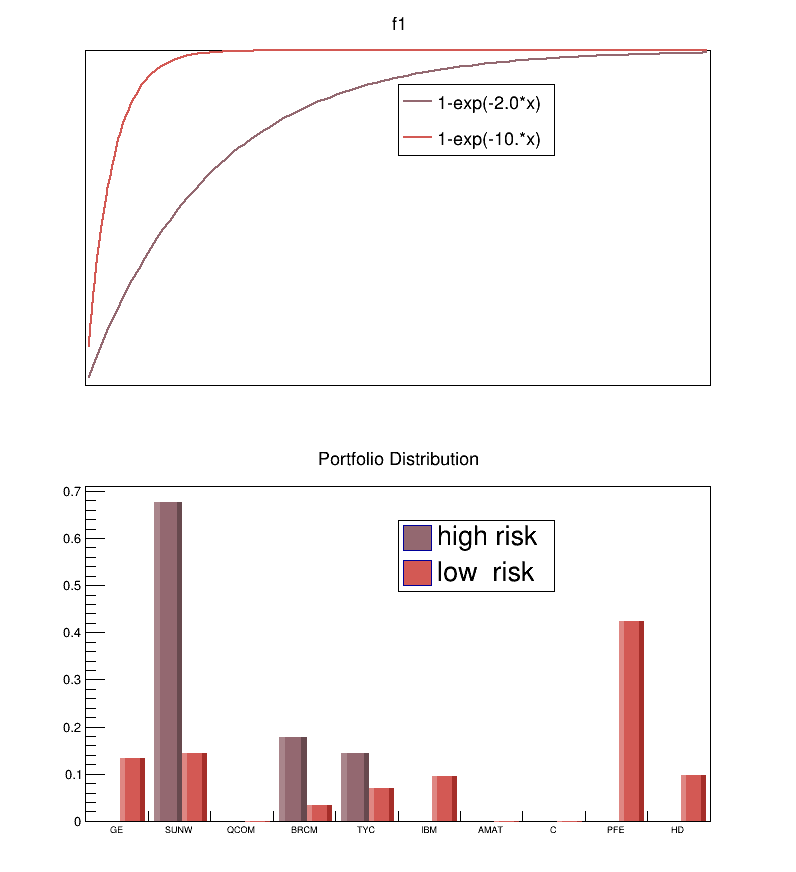

In [8]:
gROOT->GetListOfCanvases()->Draw()